<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import model_selection

In [27]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [28]:
def plot_images(test_imgs, changed_imgs, n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_imgs[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(changed_imgs[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  plt.show()

#Basic autoencoder

In [29]:
class AutoEncoder(tf.keras.models.Model):
  def __init__(self, latent_dim, shape):
    super(AutoEncoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim, activation='relu')
    ])
    self.decoder  = tf.keras.Sequential([
        tf.keras.layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
        tf.keras.layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [30]:
shape = x_test.shape[1:]
latent_dim =  64
autoencoder= AutoEncoder(latent_dim, shape)

In [31]:
autoencoder.compile(optimizer='adam',
                    loss=tf.keras.losses.MeanSquaredError())

In [32]:
autoencoder.fit(x_train,
                x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0236 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.008

In [33]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

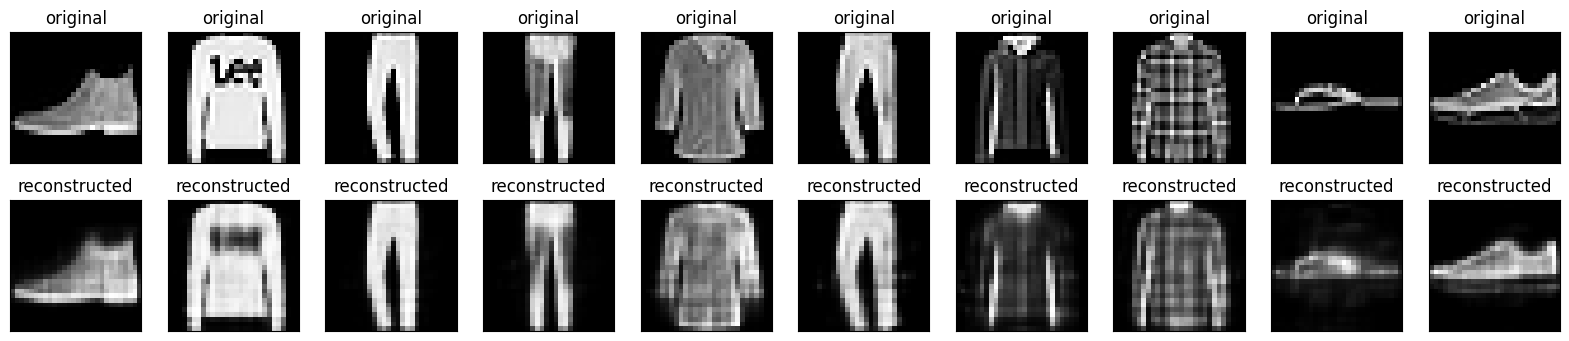

In [34]:
plot_images(x_test, decoded_imgs, n=10)

# Image denoising

In [35]:
#adding random noise to the images

noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy  = x_test  + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

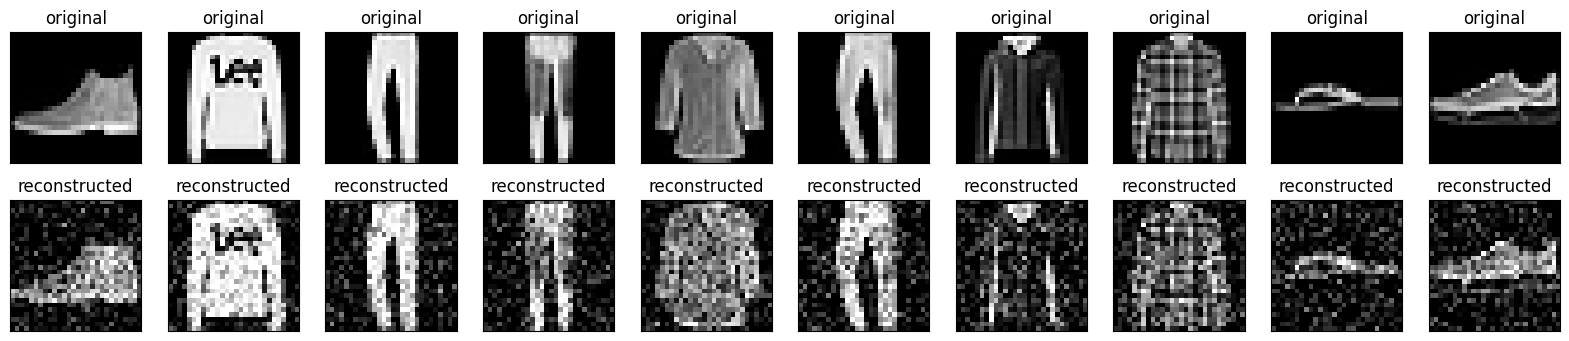

In [36]:
plot_images(x_test, x_test_noisy, n=10)

convolutional autoencoder

In [43]:
class Denoise(tf.keras.models.Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
        tf.keras.layers.Conv2D(8, 3,  activation='relu', padding='same', strides=2)
    ])
    self.decoder = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(8, 3, activation='relu', padding='same', strides=2),
        tf.keras.layers.Conv2DTranspose(16,3, activation='relu', padding='same', strides=2),
        tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [44]:
autoencoder.compile(optimizer='adam',
                    loss=tf.keras.losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy,
                x_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/20
 688/1875 [==========>...................] - ETA: 33s - loss: 0.0294